## Task 2
Assignment 1: In this assignment, I chose global-warming API (https://global-warming.org)

In [1]:
import json
import math
import numpy as np
from pathlib import Path
from datetime import datetime
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pandas.plotting import scatter_matrix
import seaborn as sns
%matplotlib inline

Key settings, including my list of cities and pre-setting a list of colours for plotting later:

In [2]:
# In total 
gl_names = ["temperature","co2","methane","nitrous-oxide","arctic"]
# Precision that we'll use for Pandas display
pd.set_option('precision', 2)
# Colors that we will use in various plots
gl_colors = ["green","darkred","orange","navy",'purple','black','red']
# Default font size
fontsize = 13

Directories for data storage:
get/create a new floder which will be used in store some prepared json file

In [3]:
# directory for raw data storage
dir_raw = Path("raw")
# directory for storing clean pre-processed data
dir_data = Path("data")
# make sure it exists
dir_data.mkdir(parents=True, exist_ok=True)

## Data Preprocessing

Before I can analyse the data, I need to transform it into a usable format.

Firstly, find all of the raw JSON files and separate them by gname:

In [4]:
global_files = {}
for gname in gl_names:
    global_files[gname] = []
for fpath in dir_raw.iterdir():
    if fpath.suffix == ".json":
        # parse the filename
        parts = fpath.stem.split(".")
        if parts[0] in gl_names:
            global_files[parts[0]].append(fpath)
#show how many raws in data files
for gname in gl_names:
    print("%s: Found %d raw data files" % (gname, len(global_files[gname])))
#     print(global_files[gname])
    

temperature: Found 1 raw data files
co2: Found 1 raw data files
methane: Found 1 raw data files
nitrous-oxide: Found 1 raw data files
arctic: Found 1 raw data files


## Data Parsing and Merging

We will define a function that will parse an individual raw JSON data file coming from the global_warming API.

In this section, before I plan to analyse data, I will achieve these steps:
1) to define a function, make sure I can use it to read file in json, and then transfer it to DataFrame

2) Read the files separately, delete useless data, change the format of some of the data and reset the index


In [5]:
#Define a function that will parse and merge a collection of raw data files:
def read_file(gname,item,time):
    with open('./raw/'+ gname +'.json','r')as f:
        json_data = json.load(f)
#         print(json_data)
    f.close()    
    
    return pd.DataFrame(json_data[item]).set_index(time)


In [6]:
#define a function that only can get json data
def show_data(gname):
    with open('./raw/'+ gname +'.json','r')as f:
        json_data = json.load(f)

    f.close()
    return json_data


I will create a new dictionary called "global_dict", this dictionary will store all Processed data

In [7]:
#this dictionary will store all Processed data
global_dict = {}

### Processing of temperature data
This temperature data provides on a monthly basis, the global mean surface temperature anomaly from 1880.04 to the present (in celsius). 

Step 1: First, read original data

In [8]:
read_file("temperature","result","time").head()
# land: Global temperature anomalies of surface land
# station: Global temperature anomalies of station

,land,station
time,,
1880.04,-0.18,-0.28
1880.13,-0.24,-0.47
1880.21,-0.08,-0.33
1880.29,-0.15,-0.53
1880.38,-0.09,-0.25


The term temperature anomaly means a departure from a reference value or long-term average. A positive anomaly indicates that the observed temperature was warmer than the reference value, while a negative anomaly indicates that the observed temperature was cooler than the reference value.(citied in https://www.ncei.noaa.gov/access/monitoring/global-temperature-anomalies)

Step 2: Split the time in the temperature table into two parts: time(year) and month

In [9]:
data = show_data("temperature")
    
for i in range(len(data["result"])):
    time = data["result"][i]['time'].split(".")
    data["result"][i]['time'] = time[0]
    month = float("0."+ time[1])
#     print(month,type(month))
    month = math.ceil(month*365/30)
#     print(month)
    data["result"][i]['month']= month

Step 3: Divide the data by month and year and store them separately in global_dict[temperature]

In [10]:
#Breakdown of data by month
global_dict["temperature"] = {'month':pd.DataFrame(data["result"]).set_index('time').apply(pd.to_numeric,errors='coerce')}
temp_month = global_dict["temperature"]['month']
temp_month.head()

,land,station,month
time,,,
1880,-0.18,-0.28,1
1880,-0.24,-0.47,2
1880,-0.08,-0.33,3
1880,-0.15,-0.53,4
1880,-0.09,-0.25,5


In [11]:
#Define a function to display the data in gname by year
def show_year(gname):
    y = global_dict[gname]['month'].drop(['month'], axis=1)
    global_dict[gname]['year'] = y.groupby(['time']).mean()
    return global_dict[gname]['year']

In [12]:
#Breakdown of data by month
show_year("temperature")
global_dict["temperature"]['year']


,land,station
time,,
1880,-0.16,-0.33
1881,-0.08,-0.26
1882,-0.10,-0.37
1883,-0.17,-0.36
1884,-0.28,-0.51
...,...,...
2018,0.84,1.12
2019,0.97,1.25
2020,1.02,1.33


In [13]:
#Combine time and month in the data by per month into one index
def reset_time(gname):
    df = global_dict[gname]['month'].reset_index()
    df['month'] = df['month'].astype("string")
    df['time'] = df[['time', 'month']].agg('.'.join, axis=1)
    df = df.drop(['month'],axis=1).set_index('time')
    return df

In [14]:
global_dict["temperature"]['month'] = reset_time("temperature")
global_dict["temperature"]['month'].head()

,land,station
time,,
1880.1,-0.18,-0.28
1880.2,-0.24,-0.47
1880.3,-0.08,-0.33
1880.4,-0.15,-0.53
1880.5,-0.09,-0.25


### Processing of CO2 data
This CO2 data provides on a quasi-daily basis, the amount of carbon dioxide (CO2) in the atmosphere from 2010.01.01 to the present. It is expressed as a mole fraction in dry air, parts per million (ppm). 

Step 1: First, read original data

In [15]:
#original data of co2
or_data = read_file("co2","co2","year")
or_data = or_data.reset_index()
or_data['time'] = or_data['year']
or_data = or_data.set_index('time').drop(['year'], axis=1)
or_data
# cycle: global seasonal cycle value;
# trend: global seasonal trend value

,cycle,day,month,trend
time,,,,
2012,393.35,20,1,391.58
2012,393.36,21,1,391.58
2012,393.37,22,1,391.59
2012,393.38,23,1,391.60
2012,393.39,24,1,391.60
...,...,...,...,...
2022,416.61,27,10,417.89
2022,416.68,28,10,417.90
2022,416.74,29,10,417.90


Step 2: Split the time in the co2 table into two parts: time(year) and month

In [16]:
#Let the data in co2 be displayed by each month
data = show_data('co2')
df = pd.DataFrame(or_data)
df = df.apply(pd.to_numeric,errors='coerce')
df = df.groupby(['time','month']).mean()
global_dict["co2"] = df.drop(['day'], axis=1)
global_dict["co2"] = {"month":global_dict["co2"].reset_index(level = "month")}
global_dict["co2"]["month"]

,month,cycle,trend
time,,,
2012,1,393.40,391.61
2012,2,393.46,391.75
2012,3,393.70,391.95
2012,4,394.32,392.16
2012,5,394.48,392.37
...,...,...,...
2022,6,418.06,417.19
2022,7,415.52,417.35
2022,8,413.87,417.51


Step 3: Divide the data by month and year and store them separately in global_dict[co2]

In [17]:
#Let the data in co2 be displayed by year
show_year("co2")
global_dict["co2"]["year"].head()

,cycle,trend
time,,
2012,392.77,392.75
2013,395.58,395.54
2014,397.57,397.60
2015,399.80,399.78
2016,403.01,403.01


In [18]:
#Combine time and month in the data by per month into one index
global_dict["co2"]['month'] = reset_time("co2")
global_dict["co2"]['month'].head()

,cycle,trend
time,,
2012.1,393.40,391.61
2012.2,393.46,391.75
2012.3,393.70,391.95
2012.4,394.32,392.16
2012.5,394.48,392.37


### Processing of methane data
This methane data provides on a monthly basis, the amount of methane(CH4) in the atmosphere from 1983 to the present. Expressed as a mole fraction in dry air, parts per million (ppm).

Step 1: First, read original data

In [19]:
read_file("methane","methane","date").head()
# average: globally averaged marine surface monthly mean data

,average,averageUnc,trend,trendUnc
date,,,,
#.year,decimal,average,average_unc,trend
1983.7,1626.58,2.10,1635.31,1.39
1983.8,1627.88,2.69,1635.92,1.33
1983.9,1638.49,2.33,1636.53,1.27
1983.10,1644.80,1.59,1637.16,1.20


Step 2: Split the time in the CH4 table into two parts: time(year) and month

In [20]:
data = show_data("methane")
    
for i in range(1,len(data["methane"])):
    time = data["methane"][i]['date'].split(".")
    data["methane"][i]['date'] = time[0]
    month = int(time[1])
    data["methane"][i]['month']= month

In [21]:
or_data = pd.DataFrame(data["methane"]).set_index('date').apply(pd.to_numeric,errors='coerce')
or_data = or_data.reset_index()
or_data['time'] = or_data['date']
or_data = or_data.set_index('time').drop(['date'], axis=1)
or_data=or_data.drop("#.year",axis = 0)
or_data.columns = ['ch4_average','ch4_averageUnc','ch4_trend','ch4_trendUnc','month']
or_data['month'] = or_data['month'].astype(int)
global_dict["methane"] = {"month":or_data}
global_dict["methane"]["month"].head()

,ch4_average,ch4_averageUnc,ch4_trend,ch4_trendUnc,month
time,,,,,
1983,1626.58,2.10,1635.31,1.39,7
1983,1627.88,2.69,1635.92,1.33,8
1983,1638.49,2.33,1636.53,1.27,9
1983,1644.80,1.59,1637.16,1.20,10
1983,1642.58,0.78,1637.83,1.12,11


Step 3: Divide the data by month and year and store them separately in global_dict[methane]

In [22]:
#Make the data in methane display by year
show_year("methane")
global_dict["methane"]["year"] = global_dict["methane"]["year"].drop(['2022'],axis=0)
# g[(g.index == "2022")]
global_dict["methane"]["year"].head()

,ch4_average,ch4_averageUnc,ch4_trend,ch4_trendUnc
time,,,,
1983,1636.64,1.75,1636.88,1.22
1984,1644.86,1.44,1644.85,0.73
1985,1657.37,1.25,1657.68,0.66
1986,1670.20,1.45,1670.17,0.83
1987,1682.81,0.92,1682.70,0.56


In [23]:
#set index with time: combine time and month
global_dict["methane"]['month'] = reset_time("methane")
global_dict["methane"]['month'].head()

,ch4_average,ch4_averageUnc,ch4_trend,ch4_trendUnc
time,,,,
1983.7,1626.58,2.10,1635.31,1.39
1983.8,1627.88,2.69,1635.92,1.33
1983.9,1638.49,2.33,1636.53,1.27
1983.10,1644.80,1.59,1637.16,1.20
1983.11,1642.58,0.78,1637.83,1.12


### Processing of nitrous-oxide data
This methane data provides on a monthly basis, the amount of nitrous oxide in the atmosphere from 2001 to the present. Expressed as a mole fraction in dry air, parts per million (ppm). 

Step 1: First, read original data

In [24]:
read_file("nitrous-oxide","nitrous","date").head()
#average: Nitrous averaged marine surface monthly mean data

,average,averageUnc,trend,trendUnc
date,,,,
#.year,decimal,average,average_unc,trend
2001.1,316.30,0.17,316.03,0.16
2001.2,316.31,0.18,316.09,0.16
2001.3,316.21,0.17,316.15,0.16
2001.4,316.12,0.15,316.22,0.16


Step 2: Split the time in the NO2 table into two parts: time(year) and month

In [25]:
data = show_data("nitrous-oxide")
    
for i in range(1,len(data["nitrous"])):
    time = data["nitrous"][i]['date'].split(".")
    data["nitrous"][i]['date'] = time[0]
    month = int(time[1])
    data["nitrous"][i]['month']= month

In [26]:
or_data = pd.DataFrame(data["nitrous"]).set_index('date').apply(pd.to_numeric,errors='coerce')
or_data = or_data.reset_index()
or_data['time'] = or_data['date']
or_data = or_data.set_index('time').drop(['date'], axis=1)
or_data=or_data.drop("#.year",axis = 0)
or_data['month'] = or_data['month'].astype(int)
or_data.columns = ['n2o_average','n2o_averageUnc','n2o_trend','n2o_trendUnc','month']
global_dict["nitrous-oxide"] = {"month":or_data}
global_dict["nitrous-oxide"]["month"].head()

,n2o_average,n2o_averageUnc,n2o_trend,n2o_trendUnc,month
time,,,,,
2001,316.30,0.17,316.03,0.16,1
2001,316.31,0.18,316.09,0.16,2
2001,316.21,0.17,316.15,0.16,3
2001,316.12,0.15,316.22,0.16,4
2001,316.11,0.15,316.28,0.15,5


Step 3: Divide the data by month and year and store them separately in global_dict[nitrous-oxide]

In [27]:
#Let the data in nitrous-oxide be displayed by year
show_year("nitrous-oxide")
#Since the averageUnc part of the data is missing in the 2022 data, it has been removed here in advance
global_dict["nitrous-oxide"]["year"] = global_dict["nitrous-oxide"]["year"].drop(['2022'],axis=0)
global_dict["nitrous-oxide"]["year"].head()

,n2o_average,n2o_averageUnc,n2o_trend,n2o_trendUnc
time,,,,
2001,316.37,0.16,316.37,0.15
2002,316.94,0.14,316.94,0.13
2003,317.63,0.13,317.61,0.12
2004,318.26,0.14,318.28,0.13
2005,318.92,0.12,318.93,0.11


In [28]:
#Combine time and month in the data by per month into one index
global_dict["nitrous-oxide"]['month'] = global_dict["nitrous-oxide"]['month'].drop(['2022'],axis=0)
global_dict["nitrous-oxide"]['month'] = reset_time("nitrous-oxide")
global_dict["nitrous-oxide"]['month'].head()

,n2o_average,n2o_averageUnc,n2o_trend,n2o_trendUnc
time,,,,
2001.1,316.30,0.17,316.03,0.16
2001.2,316.31,0.18,316.09,0.16
2001.3,316.21,0.17,316.15,0.16
2001.4,316.12,0.15,316.22,0.16
2001.5,316.11,0.15,316.28,0.15


### Processing of arctic data
This arctic data provides the average monthly arctic sea ice extent each September since 1979, derived from satellite observations.

Step 1: First, read original data

In [29]:
read_file("arctic","arcticData","year").head()
# area: average polar ice coverage

,Column1,area,data-type,extent,hemisphere,month,rank
year,,,,,,,
1979,0,4.58,Goddard,7.05,N,9,33.0
1980,1,4.87,Goddard,7.67,N,9,43.0
1981,2,4.44,Goddard,7.14,N,9,34.5
1982,3,4.43,Goddard,7.30,N,9,37.0
1983,4,4.70,Goddard,7.39,N,9,39.0


Step 2: Split the time in the NO2 table into two parts: time(year) and month

In [30]:
data = show_data("arctic")
df = pd.DataFrame(data['arcticData']).set_index('year')
or_data = df.drop(['hemisphere','data-type'], axis=1).apply(pd.to_numeric,errors='coerce')
or_data = or_data.reset_index()
or_data['time'] = or_data['year'].astype("string")
or_data = or_data.drop(['year'], axis=1)
global_dict["arctic"] = {"month":or_data}
global_dict["arctic"]['month'] = global_dict["arctic"]['month'].set_index('time')
global_dict["arctic"]['month'].head()

,Column1,area,extent,month,rank
time,,,,,
1979,0,4.58,7.05,9,33.0
1980,1,4.87,7.67,9,43.0
1981,2,4.44,7.14,9,34.5
1982,3,4.43,7.30,9,37.0
1983,4,4.70,7.39,9,39.0


Step 3: Divide the data by month and year and store them separately in global_dict[arctic]

In [31]:
#Let the data in arctic be displayed by year
m = show_year("arctic")
global_dict["arctic"]["year"] = m.reset_index()
global_dict["arctic"]["year"]['time'] = global_dict["arctic"]["year"]['time'].astype("string")
global_dict["arctic"]["year"] = global_dict["arctic"]["year"].set_index('time').drop(['Column1'],axis = 1)
global_dict["arctic"]["year"].head()

,area,extent,rank
time,,,
1979,4.58,7.05,33.0
1980,4.87,7.67,43.0
1981,4.44,7.14,34.5
1982,4.43,7.30,37.0
1983,4.70,7.39,39.0


In [32]:
#Combine time and month in the data by per month into one index
global_dict["arctic"]['month'] = global_dict["arctic"]['month'].drop(['Column1'],axis = 1)
global_dict["arctic"]['month'] = reset_time("arctic")
global_dict["arctic"]['month'].head()

,area,extent,rank
time,,,
1979.9,4.58,7.05,33.0
1980.9,4.87,7.67,43.0
1981.9,4.44,7.14,34.5
1982.9,4.43,7.30,37.0
1983.9,4.70,7.39,39.0


## Data Saving

Now write out all of the merged global warming and climate data DataFrames in JSON format, one file per global warming data. These will represent the 'clean' data that I will use next for our actual data analysis:

In [33]:
def data_save(gl_names):
    for gname in gl_names:
        for date in ["year",'month']:
            fname = "%s_%s_prepared.json" % (gname,date)
            out_path = dir_data / fname
            print("Writing %s" % out_path)
            dict_ = global_dict[gname][date]
            dict_.to_json(out_path, orient="index", indent=4)

In [34]:
data_save(gl_names)

Writing data/temperature_year_prepared.json
Writing data/temperature_month_prepared.json
Writing data/co2_year_prepared.json
Writing data/co2_month_prepared.json
Writing data/methane_year_prepared.json
Writing data/methane_month_prepared.json
Writing data/nitrous-oxide_year_prepared.json
Writing data/nitrous-oxide_month_prepared.json
Writing data/arctic_year_prepared.json
Writing data/arctic_month_prepared.json


## Data Analysis


### Temperature Analysis

The global warming api provides two types of temperature data for temperature: land and station (global temperature anomalies)

#### Step 1 
Continue to process the data briefly and calculate the maximum, minimum, average and median values for each indicator

Analysis of surface temperature change per month from 1880 to 2022, change in station temperature per month, comparison of surface and station temperature change per year
Analysis of the maximum and minimum values of temperature for each month

In [35]:
temp_feature = global_dict["temperature"]['month'].agg({'land' : ['min','max','median','mean'], 'station' : ['min','max','median','mean']})
temp_feature

,land,station
min,-0.81,-1.43
max,1.37,1.71
median,-0.03,-0.01
mean,0.06,0.09


In [36]:
#Calculate the maximum and minimum values of temperature for each year
year_temp_feature = temp_month.reset_index()
year_temp_feature = year_temp_feature.groupby('time').agg(['min', 'max','median','mean']).drop(['month'], axis=1)
year_temp_feature

land                    station                   
       min   max median  mean     min   max median  mean
time                                                    
1880 -0.24 -0.08  -0.17 -0.16   -0.61  0.24  -0.33 -0.33
1881 -0.21  0.08  -0.10 -0.08   -0.92  0.18  -0.24 -0.26
1882 -0.35  0.17  -0.15 -0.10   -0.88  0.16  -0.36 -0.37
1883 -0.36 -0.06  -0.15 -0.17   -0.75  0.30  -0.41 -0.36
1884 -0.39 -0.08  -0.30 -0.28   -0.93  0.14  -0.49 -0.51
...    ...   ...    ...   ...     ...   ...    ...   ...
2018  0.76  1.01   0.82  0.84    0.98  1.26   1.15  1.12
2019  0.85  1.17   0.94  0.97    1.13  1.45   1.23  1.25
2020  0.81  1.24   1.00  1.02    1.06  1.60   1.33  1.33
2021  0.64  0.99   0.84  0.84    0.92  1.37   1.15  1.14
2022  0.83  1.05   0.91  0.91    1.06  1.41   1.17  1.18

[143 rows x 8 columns]

I intended to analyse the maximum and minimum values of temperature for each year. However, because there is so much data, the histogram drawn is not clear enough. So I will go ahead and create a table to hold the maximum and minimum values for each decade。

In [37]:
df = year_temp_feature.reset_index().apply(pd.to_numeric,errors='ignore')
df["time"] = [x//10 for x in df["time"]]
df = df.groupby('time').mean()
df = df.reset_index()
df["time"] = [x*10 for x in df["time"]]
year_temp_feature_10y = df
year_temp_feature_10y

/Users/zws/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


time  land                    station                   
           min   max median  mean     min   max median  mean
0   1880 -0.41 -0.03  -0.20 -0.20   -0.78  0.08  -0.39 -0.38
1   1890 -0.44 -0.06  -0.22 -0.23   -0.73 -0.04  -0.33 -0.34
2   1900 -0.49 -0.10  -0.31 -0.31   -0.54 -0.01  -0.27 -0.27
3   1910 -0.52 -0.11  -0.33 -0.32   -0.57 -0.01  -0.29 -0.29
4   1920 -0.41 -0.03  -0.25 -0.24   -0.45  0.06  -0.20 -0.19
5   1930 -0.28  0.11  -0.13 -0.12   -0.31  0.23  -0.06 -0.06
6   1940 -0.11  0.22   0.03  0.05   -0.18  0.23   0.01  0.02
7   1950 -0.20  0.13  -0.05 -0.05   -0.26  0.16  -0.06 -0.05
8   1960 -0.20  0.13  -0.03 -0.03   -0.27  0.17  -0.03 -0.04
9   1970 -0.15  0.21   0.04  0.03   -0.18  0.24   0.06  0.05
10  1980  0.08  0.42   0.25  0.25    0.08  0.48   0.29  0.28
11  1990  0.20  0.60   0.39  0.38    0.25  0.74   0.47  0.47
12  2000  0.43  0.77   0.58  0.59    0.55  0.97   0.76  0.76
13  2010  0.64  1.00   0.79  0.80    0.79  1.27   1.02  1.03
14  2020  0.76  1.09   0.92  0.92    1.01  1.46   1.21  1.22

#### Step 2 draw Time - Temperature plot

In [38]:
def draw_plot(gname,index,y,i):
    plt.figure(figsize=(14,5),dpi=150)#figsize specifies the size of the image, dpi sets the sharpness of the image
    plt.subplot(2,2, i+1)
    plt.plot(y,color = gl_colors[i])
    plt.xticks(list(range(0, 142, 10)),fontsize = 8) 
    plt.title("Temperature: %s" % index,fontsize = 10)  #set title
    plt.xlabel("Time (year)",fontsize = 8)    # Set x-coordinate labeling with font size 8
    plt.ylabel("Temperature (C)",fontsize = 8)    #Set y coordinate label
    plt.show()

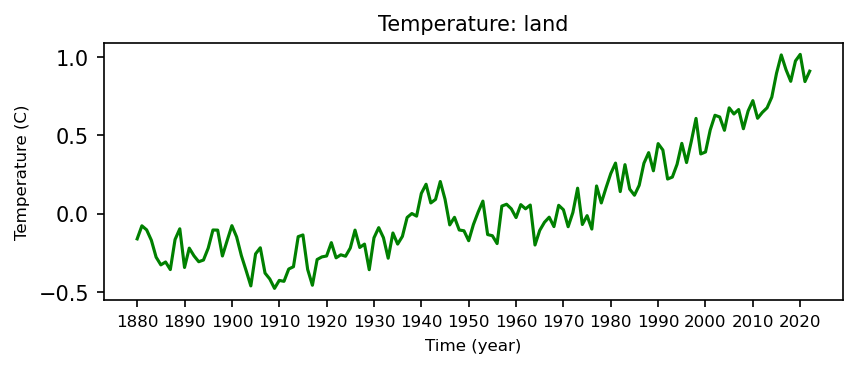

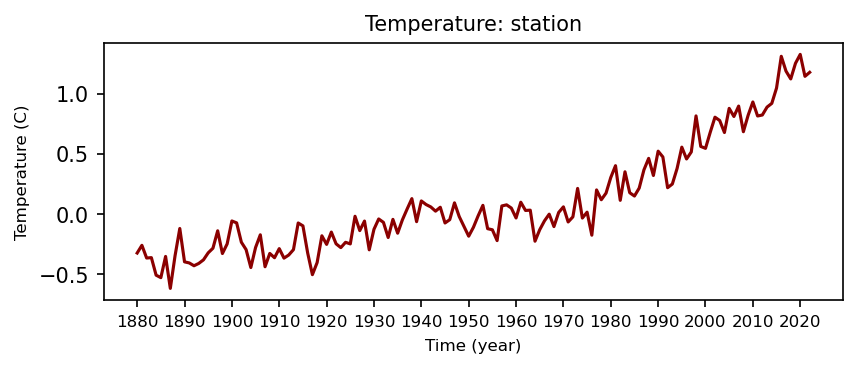

In [39]:
i=0
for index in global_dict["temperature"]['year']:
    draw_plot('temperature',index,global_dict["temperature"]['year'][index],i)
    i = i + 1

In the graph above, we can see the magnitude and trend of the anomalous temperature change from 1880 to 2020. It is clear that from 1880 to 2020, the global temperature anomalies gradually increase from negative to positive values and get higher and higher, which is not normal. This is because a positive anomaly indicates that the observed temperature was warmer than the reference value. This is an indication of global warming. In particular, the graph shows that the rate of increase in temperature has accelerated significantly since 1981. This suggests that global warming is indeed a growing problem.

Next, I will plot a graph for comparing the trends in land and station.

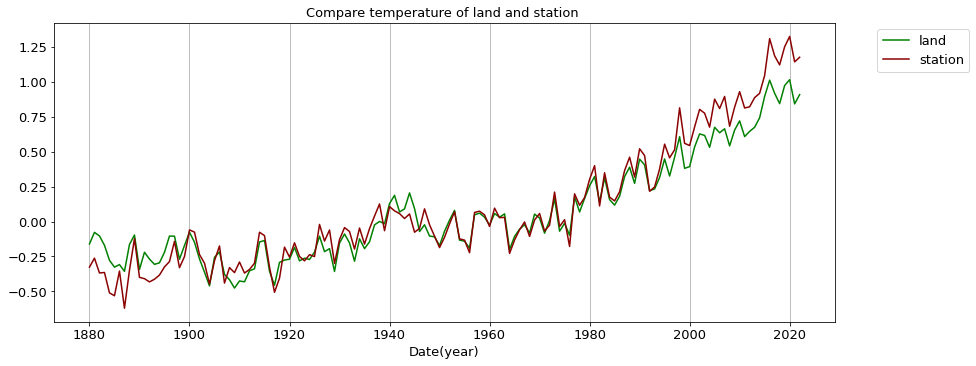

In [40]:
# plt.figure(figsize=(14,5),dpi=150)
ax = global_dict["temperature"]['year'].plot(figsize=(14,5.5), color=gl_colors, fontsize=fontsize, zorder=3)
ax.set_title("Compare temperature of land and station ", fontsize=fontsize)
ax.set_xlabel("Date(year)", fontsize=fontsize)
ax.legend(bbox_to_anchor=(1.18, 1), fontsize=fontsize)
# add an x grid
ax.xaxis.grid(True);

As can be seen from the graph above, the trend for land and station is almost identical for the same anomalous temperature change. Between 1940 and 2000, land and station temperatures were almost identical. Finally, the graph also shows that the global temperature anomalies reach a maximum in 2020: 1.46

Next step, I could look at minimum and maximum values.

In [41]:
def draw_bar(m_list,n_list,avg_list,label,name):
    x = np.arange(len(m_list))  # the label locations
    width = 0.20  # the width of the bars

    fig, ax = plt.subplots(figsize=(14,5),dpi=150)
    rects1 = ax.bar(x - width, m_list, width, label= label[0])
    rects2 = ax.bar(x + width, n_list, width, label= label[1])
    rects2 = ax.bar(x, avg_list, width, label= label[2])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel("Temperature (C)",fontsize = 16)
    ax.set_title(label[0] + ' , '+ label[1] +' and '+ label[2] +' temperature of '+ name,fontsize = 14)
    ax.set_xticks(list(range(0,15)))
    ax.set_xticklabels(list(year_temp_feature_10y['time']),rotation = 30,fontsize = 10)
    ax.legend()

    fig.tight_layout()

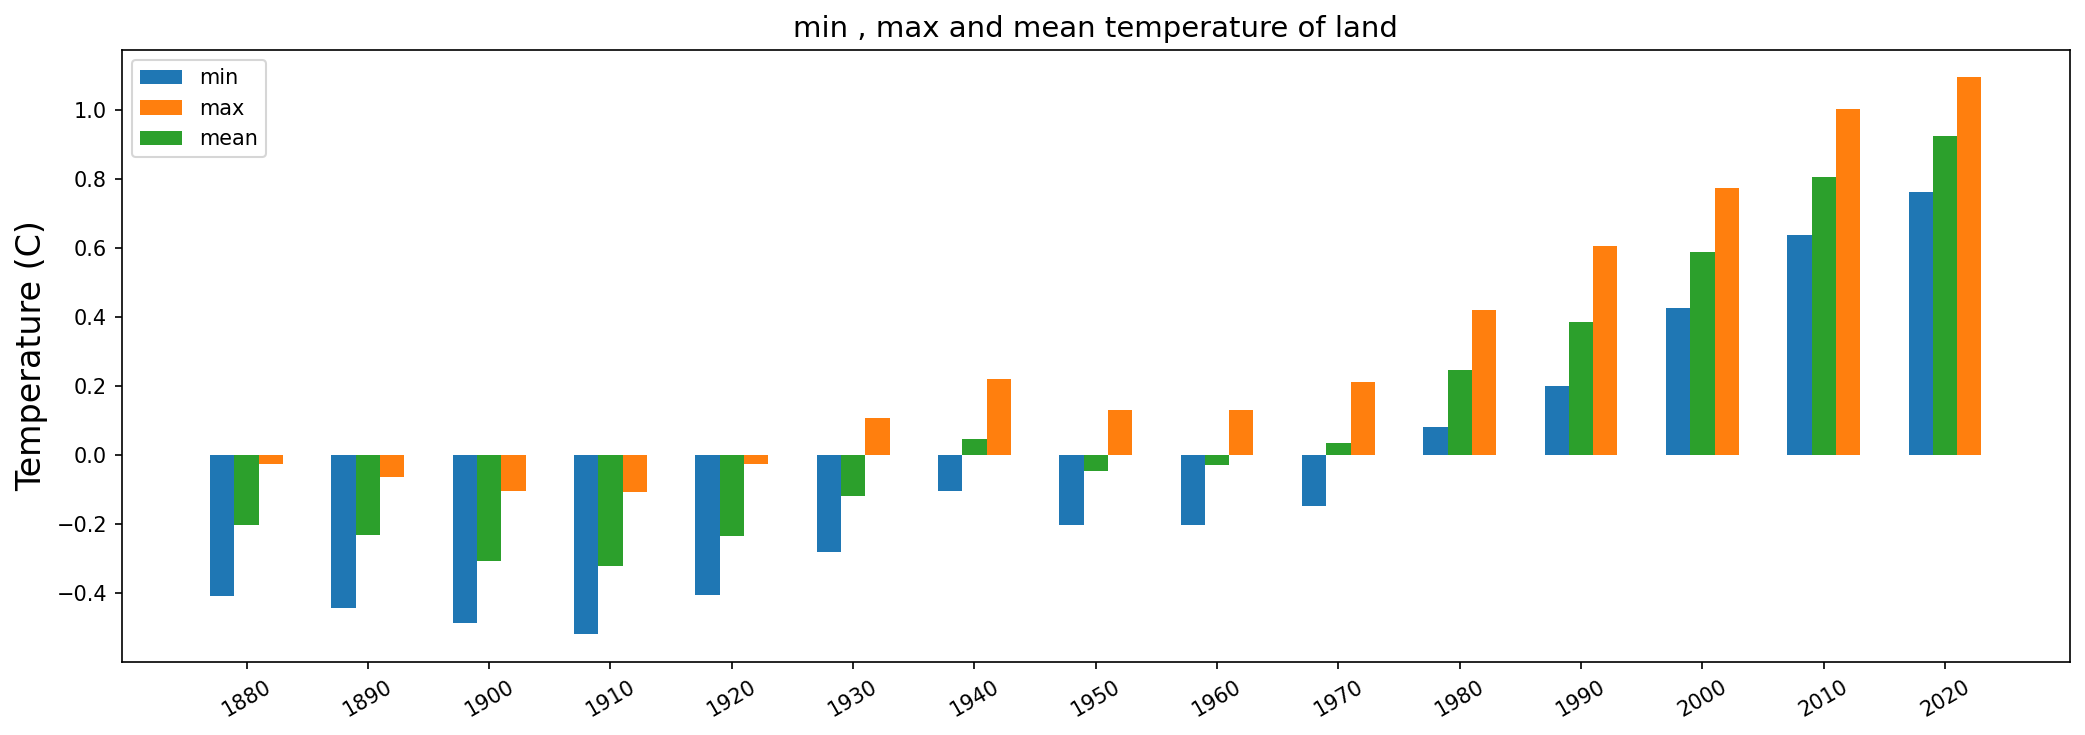

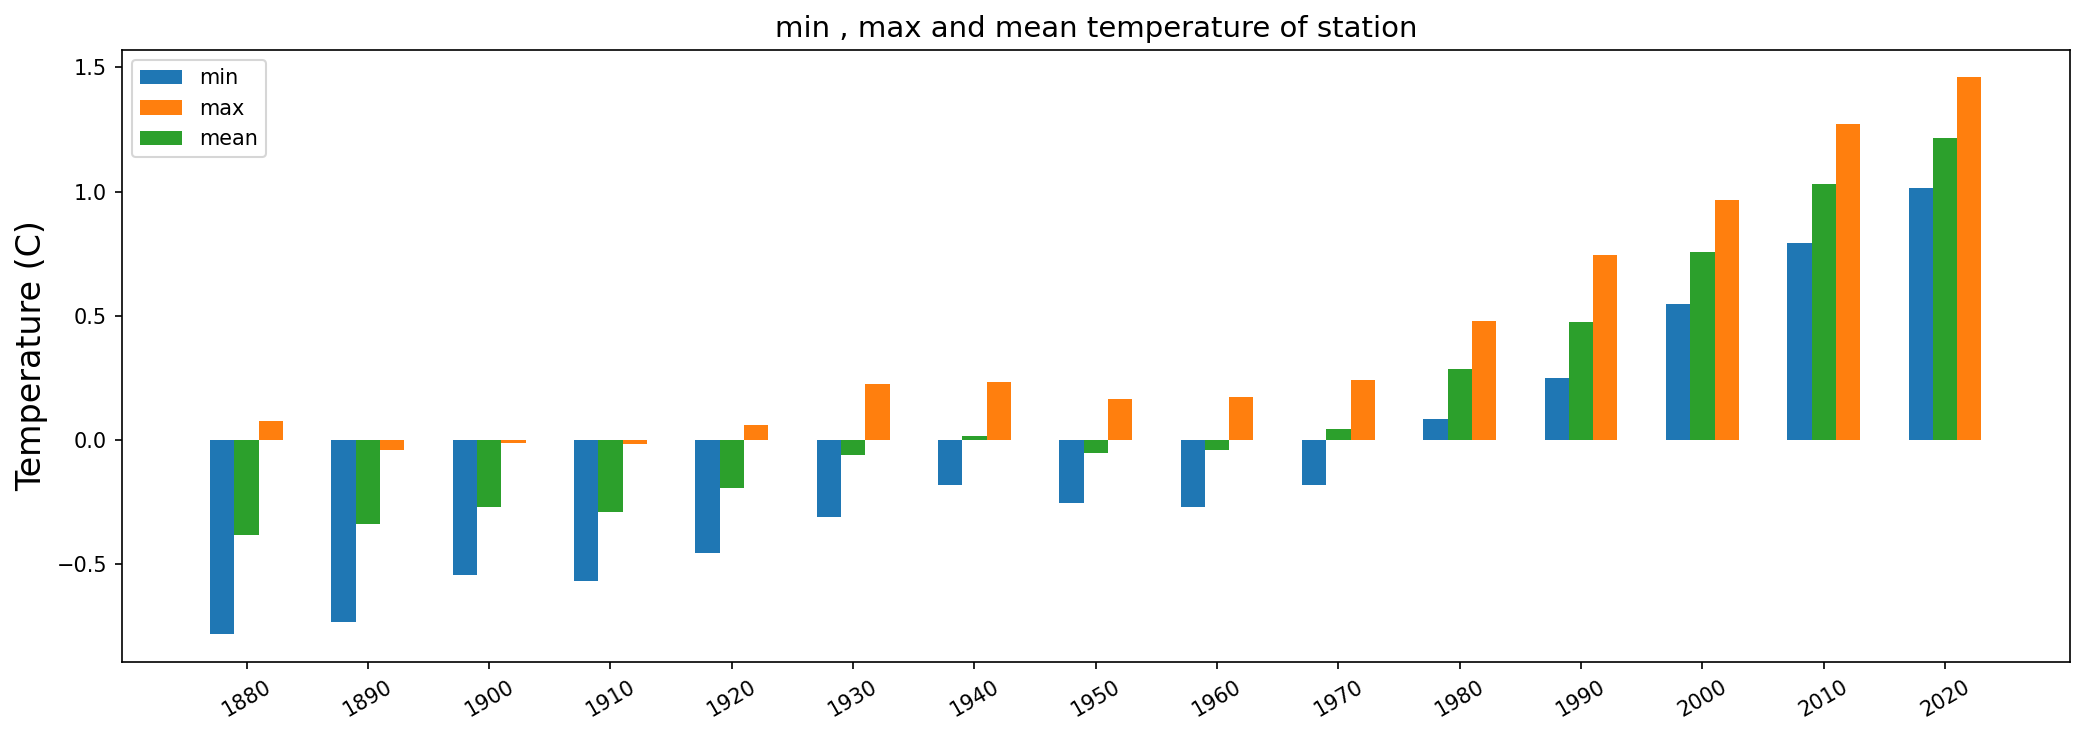

In [42]:
for name in ['land','station']:
    index = ['min','max','mean']
    m_list = year_temp_feature_10y[name][index[0]]
    n_list = year_temp_feature_10y[name][index[1]]
    avg_list = year_temp_feature_10y[name][index[2]]
    draw_bar(m_list,n_list,avg_list,index,name)

From the graphs above, the temperature data in the graph are grouped by decade. Firstly, the graph of land shows that from 1930 the global temperature anomalies are higher than normal, so that this year can be taken as the beginning of global warming. By 1980, the minimum temperature anomaly had also become positive, which shows that global warming is becoming more and more of a problem.

### CO2 anaylysis
there are two import labels in methane table: global seasonal cycle and trend value

The natural concentration of CO2 in the Earth's atmosphere was once around 280 ppm, but since the industrial revolution, human activities such as burning fossil fuels, deforestation and livestock have increased this figure by more than 30%. This section begins with a separate analysis of atmospheric carbon dioxide (CO2) concentrations from January 1, 2010 to the present.

#### Step 1 Simple processing of data

In [43]:
ayl = global_dict["co2"]["month"]
ayl.head()

,cycle,trend
time,,
2012.1,393.40,391.61
2012.2,393.46,391.75
2012.3,393.70,391.95
2012.4,394.32,392.16
2012.5,394.48,392.37


Prepare co2 data in advance for maximum, minimum, etc.

In [44]:
co2_feature = global_dict["co2"]['month'].agg({'cycle' : ['min','max','median','mean'], 'trend' : ['min','max','median','mean']})
co2_feature

,cycle,trend
min,389.30,391.61
max,419.02,417.83
median,404.95,405.33
mean,405.01,405.00


#### Step 2: Plotting CO2 concentration over time

In [45]:
def draw_plot_co2(unit,ayl):
    figure = plt.figure(figsize=(20,10),dpi = 100)
    i = 0
    for index_name in list(ayl):
        axc = figure.add_subplot(2,2, i+1)
        axc.plot(ayl[index_name],color = gl_colors[i])
        axc.set_xticks(list(range(0,130,13))) 
        axc.set_title(index_name)    
        axc.set_xlabel("Time (year)")   
        axc.set_ylabel(unit) 
        i = i+1

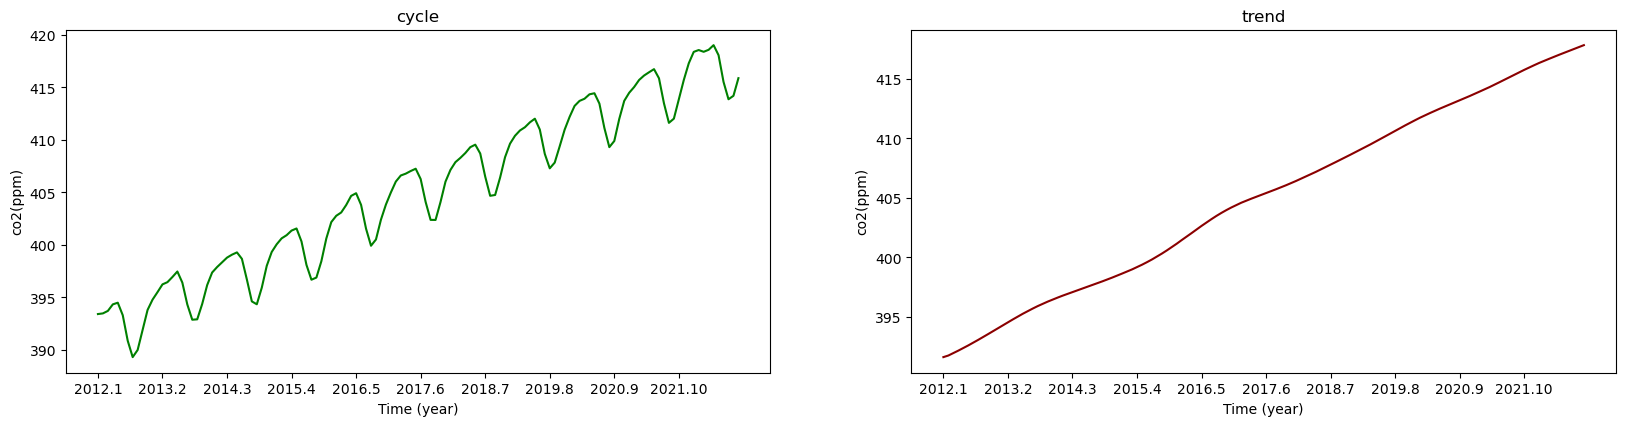

In [46]:
draw_plot_co2("co2(ppm)",ayl)

As the data on co2 concentrations starts from 2012.1 and is only ten years old, the amount of data is relatively small, so I am going to analyse the co2 concentrations on a monthly basis. The above trend graph shows that atmospheric CO2 concentrations are increasing rapidly from 2012 to the present and are predicted to increase in the future. cycle graphs also show an increasing trend in overall CO2 concentrations. As can be seen from the cycle graph, CO2 concentrations follow a yearly cycle and vary according to the seasons. In general, the annual peak in CO2 concentration is reached in April and the annual minimum in September.

### Methane anaylsis
In that section, I will analyse atmospheric methane levels from 1983 to the present.

Methane is a gas with a global warming potential several times stronger than that of carbon dioxide. For more than 650,000 years, atmospheric methane concentrations ranged from 350-800 ppb. Since the beginning of the industrial revolution, human activity has increased by about 150%.

#### Step 1 Simple processing of data

In [47]:
ayl = global_dict["methane"]["year"]
ayl.head()

,ch4_average,ch4_averageUnc,ch4_trend,ch4_trendUnc
time,,,,
1983,1636.64,1.75,1636.88,1.22
1984,1644.86,1.44,1644.85,0.73
1985,1657.37,1.25,1657.68,0.66
1986,1670.20,1.45,1670.17,0.83
1987,1682.81,0.92,1682.70,0.56


In [48]:
methane_feature = global_dict["methane"]['month'].agg({'ch4_average' : ['min','max','median','mean'], 'ch4_averageUnc' : ['min','max','median','mean']})
methane_feature

,ch4_average,ch4_averageUnc
min,1626.58,-9.99
max,1909.98,2.69
median,1774.84,0.98
mean,1772.50,0.91


#### Step 2: draw time - ch4 plot

In [49]:
def draw_plot3():
    figure = plt.figure(figsize=(20,10),dpi = 100)
    i = 0
    unit = "methane(ppm)"
    for index_name in list(ayl):
        axc = figure.add_subplot(2,2, i+1)
        axc.plot(ayl[index_name],color = gl_colors[i])
        axc.set_xticks(list(range(0, 40,4))) 
        axc.set_title(index_name)  
        axc.set_xlabel("Time (year)") 
        axc.set_ylabel(unit) 
        i = i+1

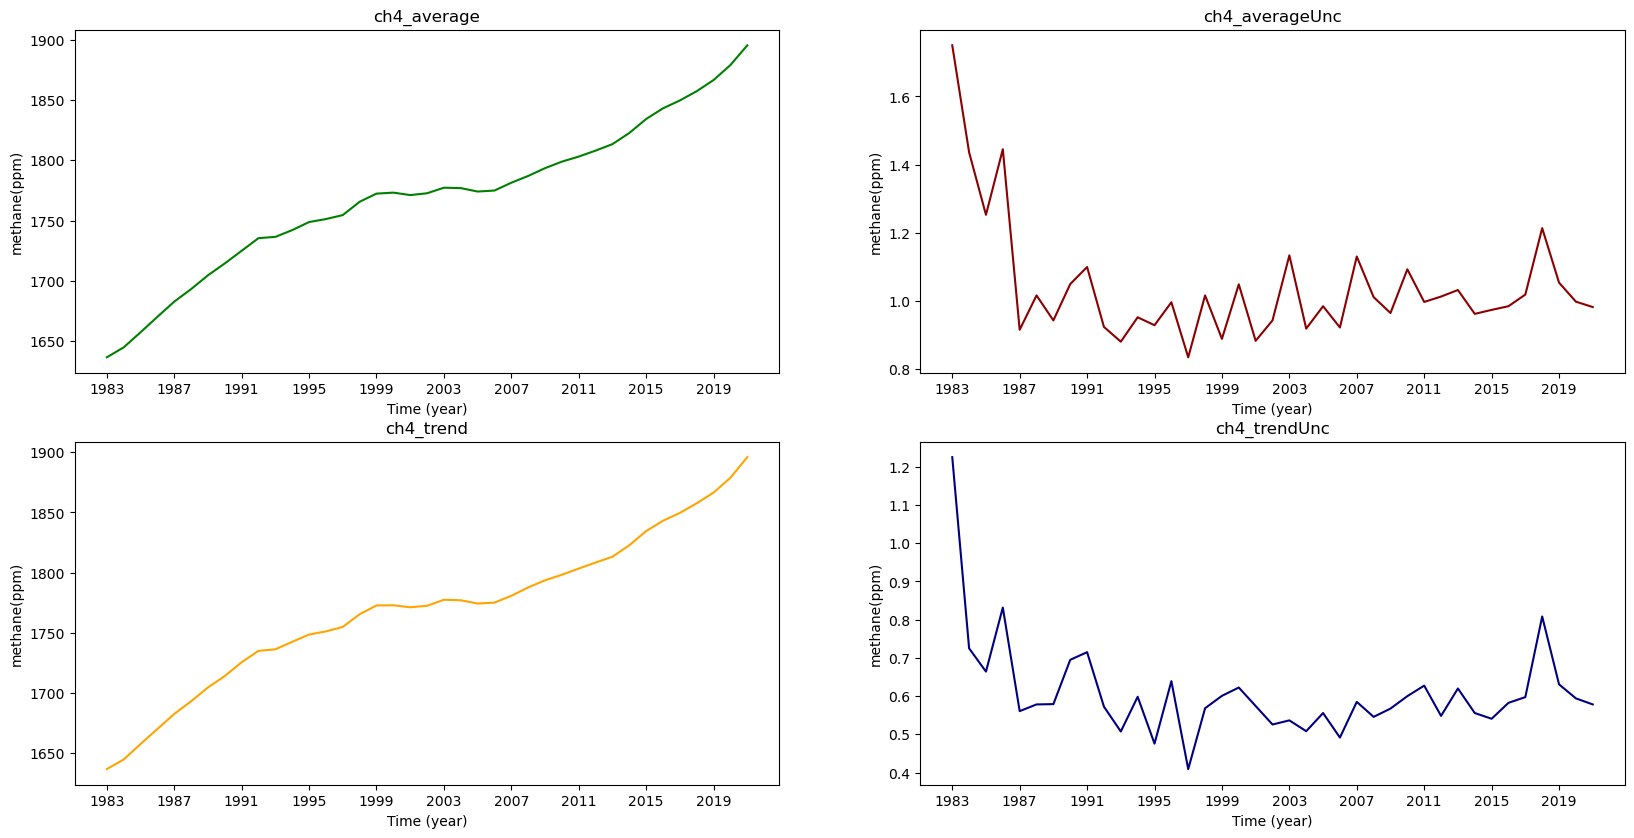

In [50]:
draw_plot3()

The data in the Methane table are mainly the annual average methane concentrations and the average Unc. In general, the tables "ch4_average" and "ch4_trend" show a clear upward trend in methane concentrations in the atmosphere from 1983 to 2022. However, unlike the changes in carbon dioxide concentrations, methane concentrations increase slowly from 1995 to 2007 and almost stabilise. However, from 2007 onwards methane concentrations suddenly began to increase rapidly. There is no strong correlation between the average methane concentration of Unc. and methane concentration in the above graph.

### Nitrous-oxide anaylsis
In this section, I will analyse the changes in atmospheric nitrous oxide levels from 2001 to the present

In [51]:
ayl = global_dict["nitrous-oxide"]["year"]
ayl.head()

,n2o_average,n2o_averageUnc,n2o_trend,n2o_trendUnc
time,,,,
2001,316.37,0.16,316.37,0.15
2002,316.94,0.14,316.94,0.13
2003,317.63,0.13,317.61,0.12
2004,318.26,0.14,318.28,0.13
2005,318.92,0.12,318.93,0.11


In [52]:
nitrous_feature = global_dict["nitrous-oxide"]['month'].agg({'n2o_average' : ['min','max','median','mean'], 'n2o_averageUnc' : ['min','max','median','mean']})
nitrous_feature

,n2o_average,n2o_averageUnc
min,316.11,0.11
max,335.10,0.18
median,324.07,0.14
mean,324.51,0.14


In [53]:
def draw_plot4():
    figure = plt.figure(figsize=(20,10),dpi = 100)
    i = 0
    unit = "nitrous oxide(ppm)"
    for index_name in list(ayl):
        axc = figure.add_subplot(2,2, i+1)
        axc.plot(ayl[index_name],color = gl_colors[i])
        axc.set_xticks(list(range(0, 22,2))) 
#         axc.set_xticklabels(list(range(2012, 2022)))
#         axc.set_yticklabels(fontsize=6)
        axc.set_title(index_name,fontsize=14)
        axc.set_xlabel("Time (year)")   
        axc.set_ylabel(unit)  
        i = i+1

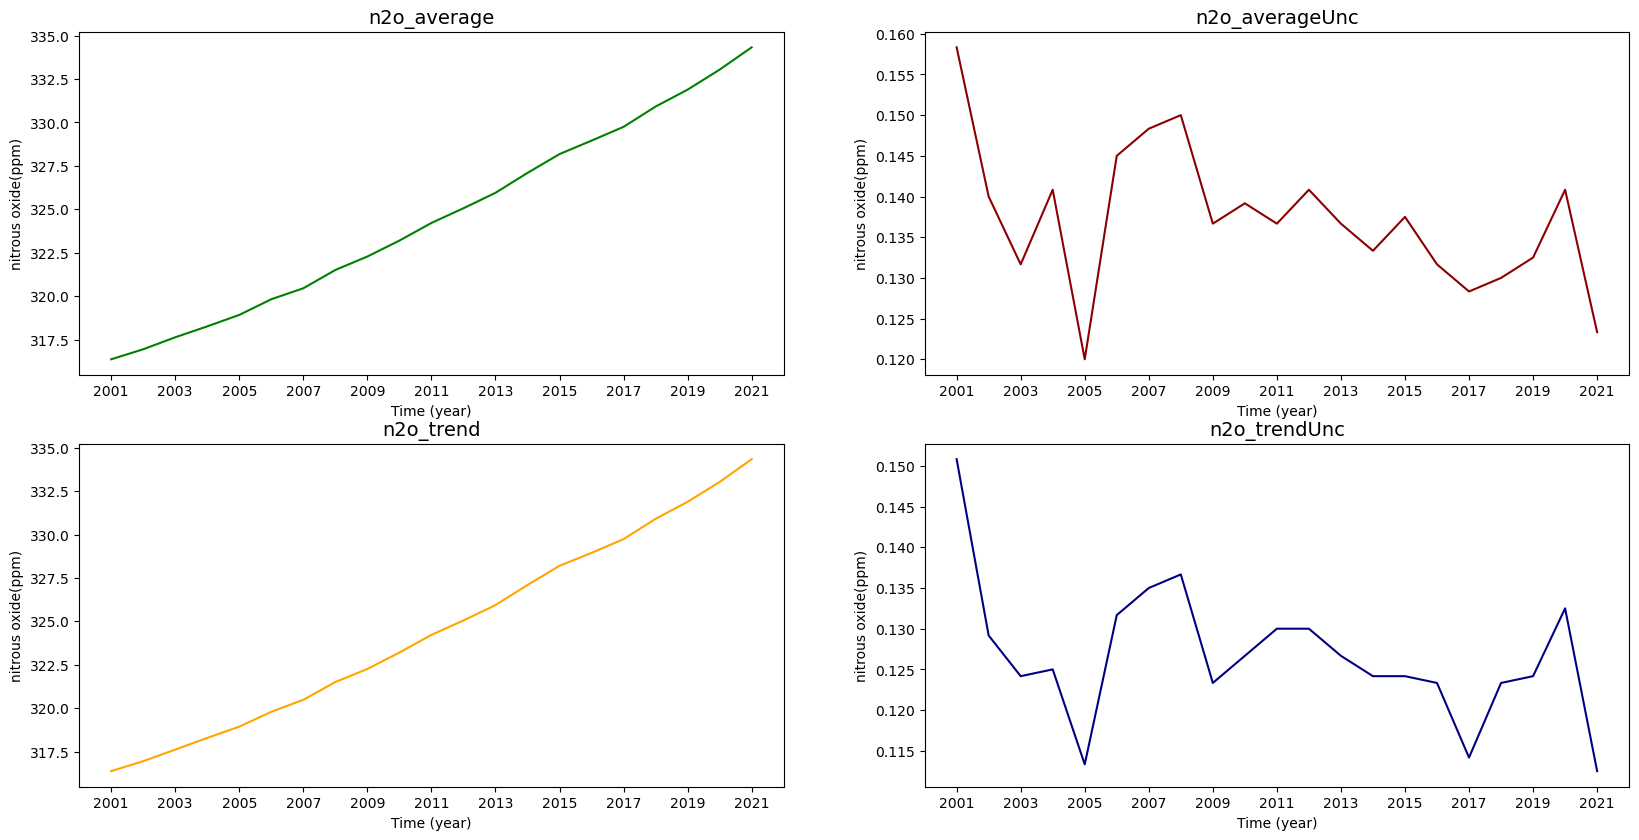

In [54]:
draw_plot4()

The concentration of NO2 is also increasing with time. the change in NO2 concentration follows a very similar trend to the change in CO2 and may also correlate with the change in CH4. So in the subsequent steps I intend to analyse the correlation between the changes in the concentrations of the different gases

### Arctic anaylsis
In this section, I will analyse the average Arctic sea ice extent in September each year since 1979

In [55]:
ayl = global_dict["arctic"]["year"]
ayl.head()

,area,extent,rank
time,,,
1979,4.58,7.05,33.0
1980,4.87,7.67,43.0
1981,4.44,7.14,34.5
1982,4.43,7.30,37.0
1983,4.70,7.39,39.0


In [56]:
arctic_feature = global_dict["arctic"]['month'].agg({'area' : ['min','max','median','mean'], 'extent' : ['min','max','median','mean']})
arctic_feature

,area,extent
min,2.41,3.57
max,5.64,7.67
median,4.29,6.12
mean,4.14,5.99


In [57]:
def draw_plot5():
    figure = plt.figure(figsize=(20,10),dpi = 100)
    i = 0
    unit = "Million square km"
    for index_name in list(ayl):
        axc = figure.add_subplot(2,3, i+1)
        axc.plot(ayl[index_name],color = gl_colors[i])
        axc.set_xticks(list(range(0, 55,10))) 
        axc.set_title(index_name)  
        axc.set_xlabel("Time (year)") 
        axc.set_ylabel(unit) 
        i = i+1

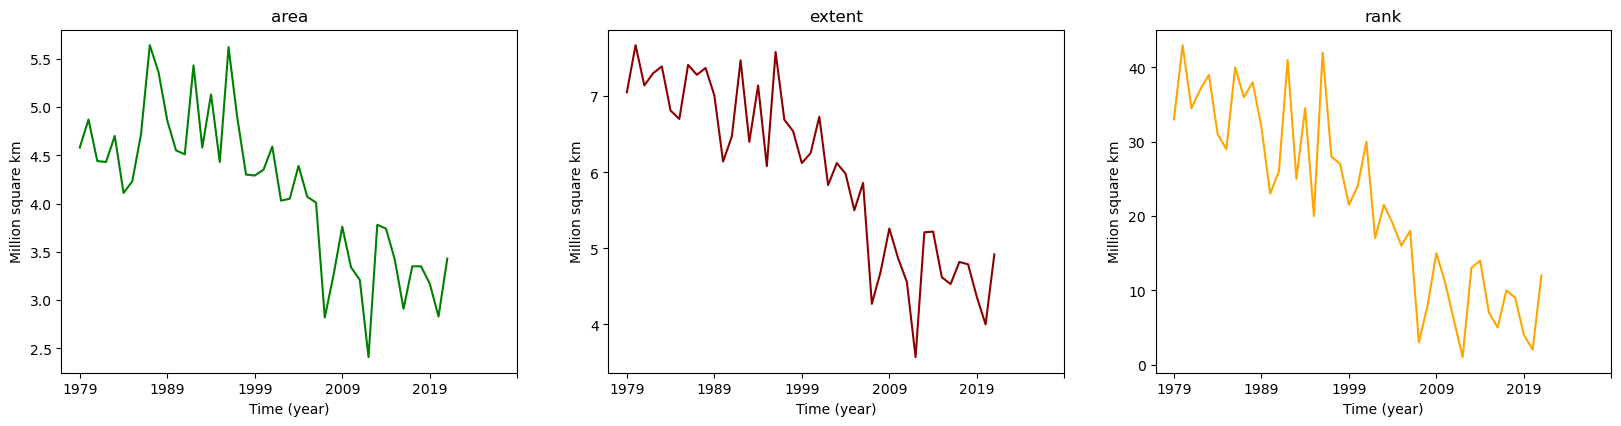

In [58]:
draw_plot5()

The above graph shows that the area of Arctic marine ice is gradually decreasing. Between 1979 and 1999, the area of Arctic marine ice remained almost constant. I found that one of the more pronounced changes in global temperature anomalies also occurred in 1999, and may be related to the change in the size of the Arctic ice. Therefore, I intend to analyse their association further.

### Analysis of special values

I will plot some histograms of extreme values

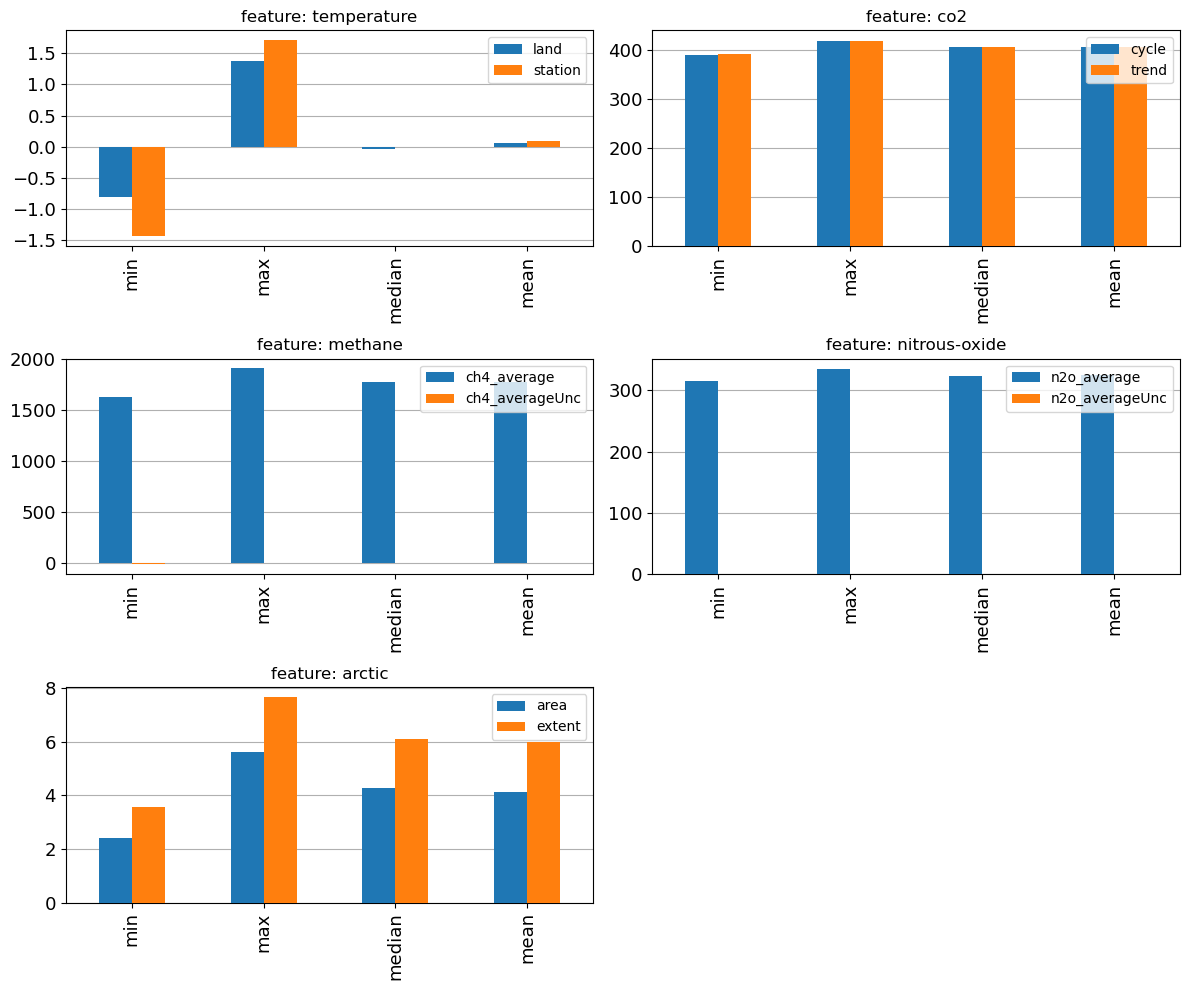

In [59]:
## Plotting extreme value bar graphs
list_f = [temp_feature,co2_feature,methane_feature,nitrous_feature,arctic_feature]
i = 0
fig = plt.figure(figsize=(12,10),dpi = 100)
for fname in list_f:
    axc = fig.add_subplot(3, 2, i+1)
    ax = fname.plot.bar(ax=axc, fontsize=fontsize, zorder=3)
    ax.set_title("feature: %s" % gl_names[i])
    ax.yaxis.grid(True);
    i = i+1
fig.tight_layout()

The bar graphs above show the maximum, minimum and average values for temperature, co2, methane, nitrous-oxide and arctic respectively. Just by comparing the difference between the maximum, minimum and average values, co2 varies the least and arctic varies the most.

## Data pre-processing
creating joint tables of multiple data

In [60]:
#Define a function to create a new table
def correlations():
    left = global_dict["temperature"]['year']
    for gname in gl_names[1:]:
        right = global_dict[gname]["year"]
        result = pd.merge(left, right, how='inner', on=['time'])
        left = result
    result = pd.DataFrame(result).sort_index()
    return result.dropna()

In [61]:
correlations_all = correlations()
correlations_all.head()

,land,station,cycle,trend,ch4_average,ch4_averageUnc,ch4_trend,ch4_trendUnc,n2o_average,n2o_averageUnc,n2o_trend,n2o_trendUnc,area,extent,rank
time,,,,,,,,,,,,,,,
2012,0.65,0.82,392.77,392.75,1808.10,1.01,1808.39,0.55,325.06,0.14,325.05,0.13,2.41,3.57,1.0
2013,0.67,0.89,395.58,395.54,1813.48,1.03,1813.18,0.62,325.95,0.14,325.94,0.13,3.78,5.21,13.0
2014,0.74,0.92,397.57,397.60,1822.74,0.96,1822.73,0.56,327.09,0.13,327.10,0.12,3.74,5.22,14.0
2015,0.90,1.05,399.80,399.78,1834.35,0.97,1834.51,0.54,328.18,0.14,328.20,0.12,3.42,4.62,7.0
2016,1.01,1.31,403.01,403.01,1843.19,0.98,1843.10,0.58,328.95,0.13,328.95,0.12,2.91,4.53,5.0


In [62]:
corr = correlations_all.drop(['station','trend',"ch4_trend","ch4_trendUnc","n2o_trend","n2o_trendUnc",'extent','rank'], axis=1)
corr.head()

,land,cycle,ch4_average,ch4_averageUnc,n2o_average,n2o_averageUnc,area
time,,,,,,,
2012,0.65,392.77,1808.10,1.01,325.06,0.14,2.41
2013,0.67,395.58,1813.48,1.03,325.95,0.14,3.78
2014,0.74,397.57,1822.74,0.96,327.09,0.13,3.74
2015,0.90,399.80,1834.35,0.97,328.18,0.14,3.42
2016,1.01,403.01,1843.19,0.98,328.95,0.13,2.91


Create a new temp and co2,NO2,CH4 association table

In [63]:
def correlations2():
    left = global_dict["temperature"]['month']
    for gname in gl_names[1:4]:
        right = global_dict[gname]["month"]
        result = pd.merge(left, right, how='inner', on=['time'])
        left = result
    result = pd.DataFrame(result).sort_index()
    return result.dropna()

In [64]:
correlations_temp = correlations2()
correlations_temp.head(8)
corr2 = correlations_temp.drop(['station','trend',"ch4_averageUnc","ch4_trend","ch4_trendUnc","n2o_averageUnc","n2o_trend","n2o_trendUnc"], axis=1)
corr2.head()

,land,cycle,ch4_average,n2o_average
time,,,,
2012.1,0.49,393.40,1807.32,324.90
2012.10,0.79,391.90,1814.71,325.28
2012.11,0.78,393.80,1815.84,325.43
2012.12,0.53,394.77,1814.61,325.53
2012.2,0.49,393.46,1808.25,324.97


In [65]:
#Create a correlation table of temp and co2 concentrations
left = global_dict["temperature"]["year"]
right = global_dict["co2"]["year"]
temp_co2 = pd.merge(left, right, how='inner', on=['time'])
temp_co2.head()

,land,station,cycle,trend
time,,,,
2012,0.65,0.82,392.77,392.75
2013,0.67,0.89,395.58,395.54
2014,0.74,0.92,397.57,397.60
2015,0.90,1.05,399.80,399.78
2016,1.01,1.31,403.01,403.01


In [66]:
#Create a correlation table of temp and ch4 concentrations
left = global_dict["temperature"]["month"]
right = global_dict["methane"]["month"]
temp_ch4 = pd.merge(left, right, how='inner', on=['time'])
temp_ch4 = temp_ch4.drop(['land','ch4_averageUnc','ch4_trend','ch4_trendUnc'],axis=1)
temp_ch4.head()

,station,ch4_average
time,,
1983.7,0.18,1626.58
1983.8,0.46,1627.88
1983.9,0.52,1638.49
1983.10,0.22,1644.80
1983.11,0.29,1642.58


In [67]:
#Create an associative table of temp, ch4 and Arctic
left = global_dict["temperature"]["year"]
right = global_dict["methane"]["year"]
tc = pd.merge(left, right, how='inner', on=['time'])
tc = tc.drop(['land','ch4_averageUnc','ch4_trend','ch4_trendUnc'],axis=1)
left = tc
right = global_dict["arctic"]["year"]
tca = pd.merge(left, right, how='inner', on=['time'])
tca = tca.drop(['rank','extent'], axis = 1)
tca.head()

,station,ch4_average,area
time,,,
1983,0.35,1636.64,4.70
1984,0.17,1644.86,4.11
1985,0.15,1657.37,4.23
1986,0.21,1670.20,4.72
1987,0.36,1682.81,5.64


### Data standardisation
As many of the data have different units, the values vary considerably. Therefore, in order to facilitate comparisons, a standard for the data needs to be harmonised, so before these data can be analysed, they need to be standardised and calculated

In [68]:
# Define normalized functions
def data_Znorm(df, cols):
    df_n = df.copy()
    for col in cols:
        u = df_n[col].mean()
        std = df_n[col].std()
        df_n[col + '_Zn'] = (df_n[col] - u) / std
        df_n = df_n.drop([col],axis = 1)
    return(df_n)

In [69]:
# Standardised data
# Processed data conform to a standard normal distribution, i.e. mean of 0 and standard deviation of 1
df_z = data_Znorm(corr,list(corr))
df_z

,land_Zn,cycle_Zn,ch4_average_Zn,ch4_averageUnc_Zn,n2o_average_Zn,n2o_averageUnc_Zn,area_Zn
time,,,,,,,
2012,-1.58,-1.49,-1.37,-0.14,-1.46,1.31,-1.96
2013,-1.37,-1.12,-1.18,0.12,-1.17,0.57,1.28
2014,-0.85,-0.85,-0.85,-0.84,-0.79,-0.03,1.19
2015,0.29,-0.56,-0.45,-0.68,-0.44,0.72,0.43
2016,1.17,-0.13,-0.13,-0.53,-0.18,-0.33,-0.78
2017,0.46,0.20,0.10,-0.06,0.08,-0.93,0.26
2018,-0.09,0.49,0.37,2.62,0.46,-0.63,0.26
2019,0.88,0.83,0.69,0.42,0.78,-0.18,-0.16
2020,1.20,1.17,1.13,-0.35,1.16,1.31,-0.97


In [70]:
#Rename data labels
corr_z = df_z
corr_z.columns = ['Temperature','CO2','CH4','CH4_Unc','N2O','N2O_Unc','Arctic area']
corr.columns = ['Temperature','CO2','CH4','CH4_Unc','N2O','N2O_Unc','Arctic area']
corr_z.head()

,Temperature,CO2,CH4,CH4_Unc,N2O,N2O_Unc,Arctic area
time,,,,,,,
2012,-1.58,-1.49,-1.37,-0.14,-1.46,1.31,-1.96
2013,-1.37,-1.12,-1.18,0.12,-1.17,0.57,1.28
2014,-0.85,-0.85,-0.85,-0.84,-0.79,-0.03,1.19
2015,0.29,-0.56,-0.45,-0.68,-0.44,0.72,0.43
2016,1.17,-0.13,-0.13,-0.53,-0.18,-0.33,-0.78


In [71]:
corr2_z = data_Znorm(corr2,list(corr2))
corr2_z.columns = ['Temperature','CO2','CH4','N2O']
corr2.columns = ['Temperature','CO2','CH4','N2O']
corr2_z.head()

,Temperature,CO2,CH4,N2O
time,,,,
2012.1,-2.13,-1.44,-1.43,-1.58
2012.10,-0.39,-1.64,-1.16,-1.45
2012.11,-0.45,-1.38,-1.12,-1.40
2012.12,-1.90,-1.25,-1.17,-1.36
2012.2,-2.13,-1.43,-1.39,-1.56


In [72]:
temp_ch4_z = data_Znorm(temp_ch4,list(temp_ch4))
temp_ch4_z.columns = ['Temperature','CH4']
temp_ch4_z.head()

,Temperature,CH4
time,,
1983.7,-1.47,-2.32
1983.8,-0.69,-2.30
1983.9,-0.52,-2.13
1983.10,-1.36,-2.03
1983.11,-1.17,-2.06


In [73]:
tca_z = data_Znorm(tca,list(tca))
tca_z.columns = ['Temperature','CH4','arctic area']
tca_z.head()

,Temperature,CH4,arctic area
time,,,
1983,-1.05,-2.09,0.75
1984,-1.58,-1.96,0.02
1985,-1.66,-1.76,0.17
1986,-1.46,-1.56,0.77
1987,-1.00,-1.36,1.90


### Plotting correlation images
First, I'm going to plot the correlation between temperature, CO2 concentration, methane concentration and N2O concentration on a monthly basis

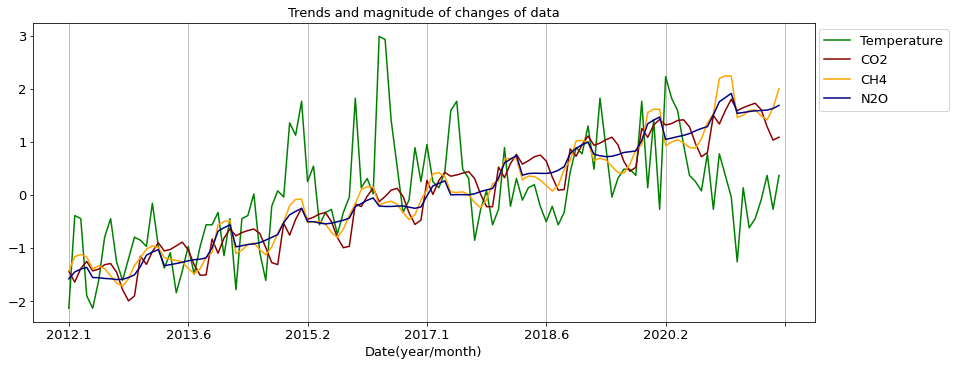

In [74]:
# plt.figure(figsize=(14,5),dpi=150)
ax = corr2_z.plot(figsize=(14,5.5), color=gl_colors, fontsize=fontsize, zorder=3)
ax.set_title("Trends and magnitude of changes of data", fontsize=fontsize)
ax.set_xlabel("Date(year/month)", fontsize=fontsize)
ax.legend(bbox_to_anchor=(1.18, 1), fontsize=fontsize)
# add an x grid
ax.xaxis.grid(True);

As I thought earlier when analysing the individual data, the trends in temperature, CO2 concentration, methane concentration and N2O concentration are almost identical. In particular, the changes in CO2, methane and N2O are almost identical, and all three variables are very cyclical, with peaks occurring at almost the same time each year. This suggests that these three variables are easily influenced by each other. Temperature is also influenced by the concentration of these three gases, but the correlation is not particularly high. Also, as can be seen from the graph above, there is a certain periodicity in the variation of temperature. However, unlike the other three variables, the periodicity of temperature is much shorter.

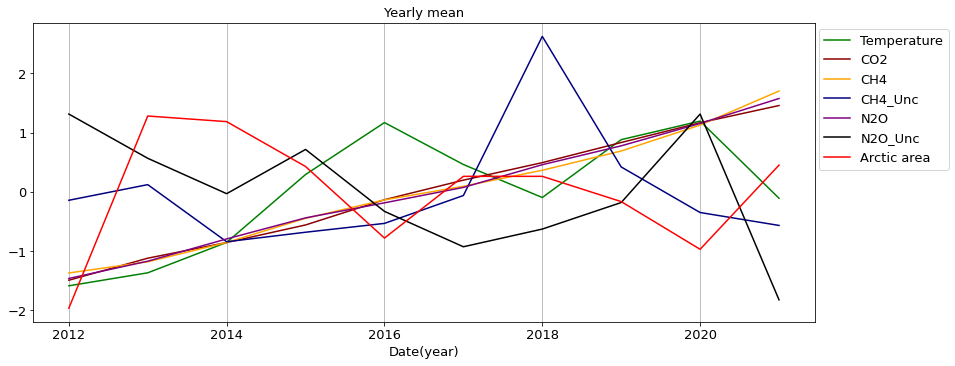

In [75]:
# plt.figure(figsize=(14,5),dpi=150)
ax = corr_z.plot(figsize=(14,5.5), color=gl_colors, fontsize=fontsize, zorder=3)
ax.set_title("Yearly mean", fontsize=fontsize)
ax.set_xlabel("Date(year)", fontsize=fontsize)
ax.legend(bbox_to_anchor=(1.18, 1), fontsize=fontsize)
# add an x grid
ax.xaxis.grid(True);

The data in the graph above is displayed on a yearly basis, and because it is an average for each year, it gives a clearer picture of the general trend of the data than if it were displayed on a monthly basis. For example, the graph shows that the value of CH4_Unc is anomalous in 2018. The data for the three gas concentrations almost overlap.

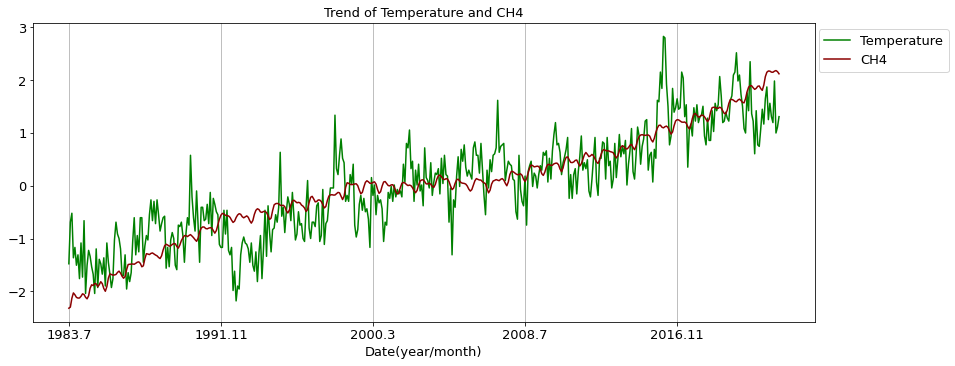

In [76]:
# plt.figure(figsize=(14,5),dpi=150)
ax = temp_ch4_z.plot(figsize=(14,5.5), color=gl_colors, fontsize=fontsize, zorder=3)
ax.set_title("Trend of Temperature and CH4", fontsize=fontsize)
ax.set_xlabel("Date(year/month)", fontsize=fontsize)
ax.legend(bbox_to_anchor=(1.18, 1), fontsize=fontsize)
# add an x grid
ax.xaxis.grid(True);

Although I did not find a strong correlation between temperature and other gas concentrations in the graph "Trends and magnitude of changes of data", I felt that this problem could be caused by insufficient data. So I analysed the relationship between temperature and methane concentration again. From July 1983 to the present, the changes in temperature and methane concentration almost overlap, so this analysis demonstrates that temperature changes are clearly influenced by methane changes. And the other data are highly correlated with changes in methane concentration, which would suggest that changes in temperature are influenced by changes in the concentration of those three gases.

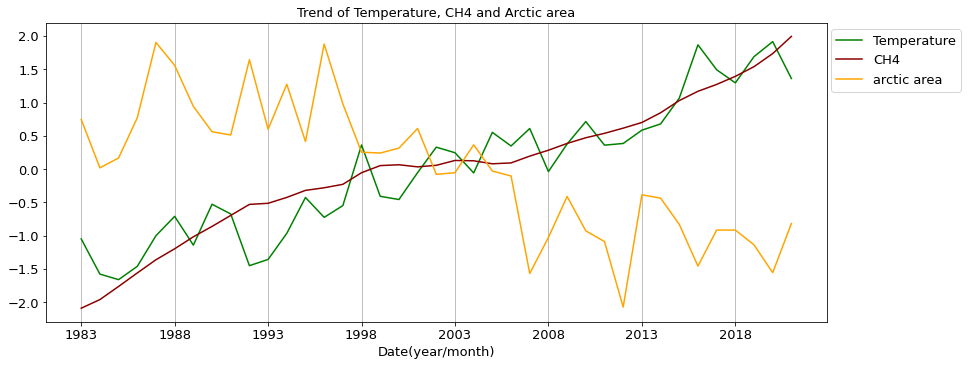

In [77]:
# plt.figure(figsize=(14,5),dpi=150)
ax = tca_z.plot(figsize=(14,5.5), color=gl_colors, fontsize=fontsize, zorder=3)
ax.set_title("Trend of Temperature, CH4 and Arctic area", fontsize=fontsize)
ax.set_xlabel("Date(year/month)", fontsize=fontsize)
ax.legend(bbox_to_anchor=(1.18, 1), fontsize=fontsize)
# add an x grid
ax.xaxis.grid(True);

When I was analysing the previous data, I felt that the area of Arctic ice should be affected by greenhouse gases and temperature. Therefore, I have plotted this graph. As you can see from the graph above, the area of Arctic marine ice is negatively correlated with temperature and also with methane concentration. In other words, an increase in temperature leads to a decrease in the area of Arctic marine ice.

In [78]:
def draw_plot2():
    figure = plt.figure(figsize=(20,15),dpi = 100)
    i = 0
    unit = ['Temperature(C)','carbon dioxide(ppm)','carbon dioxide(ppm)','methane(ppm)','nitrous oxide(ppm)','nitrous oxide(ppm)','arctic sea ice extent']
    for index_name in list(corr):
        axc = figure.add_subplot(3,3, i+1)
        axc.plot(corr[index_name],color = gl_colors[i])
        axc.set_xticks(list(range(0, 10))) 
        axc.set_xticklabels(list(range(2012, 2022)))
#         axc.set_yticklabels(fontsize=6)
        axc.set_title(index_name)   
        axc.set_xlabel("Time (year)")  
        axc.set_ylabel("%s" % unit[i]) 
        i = i+1

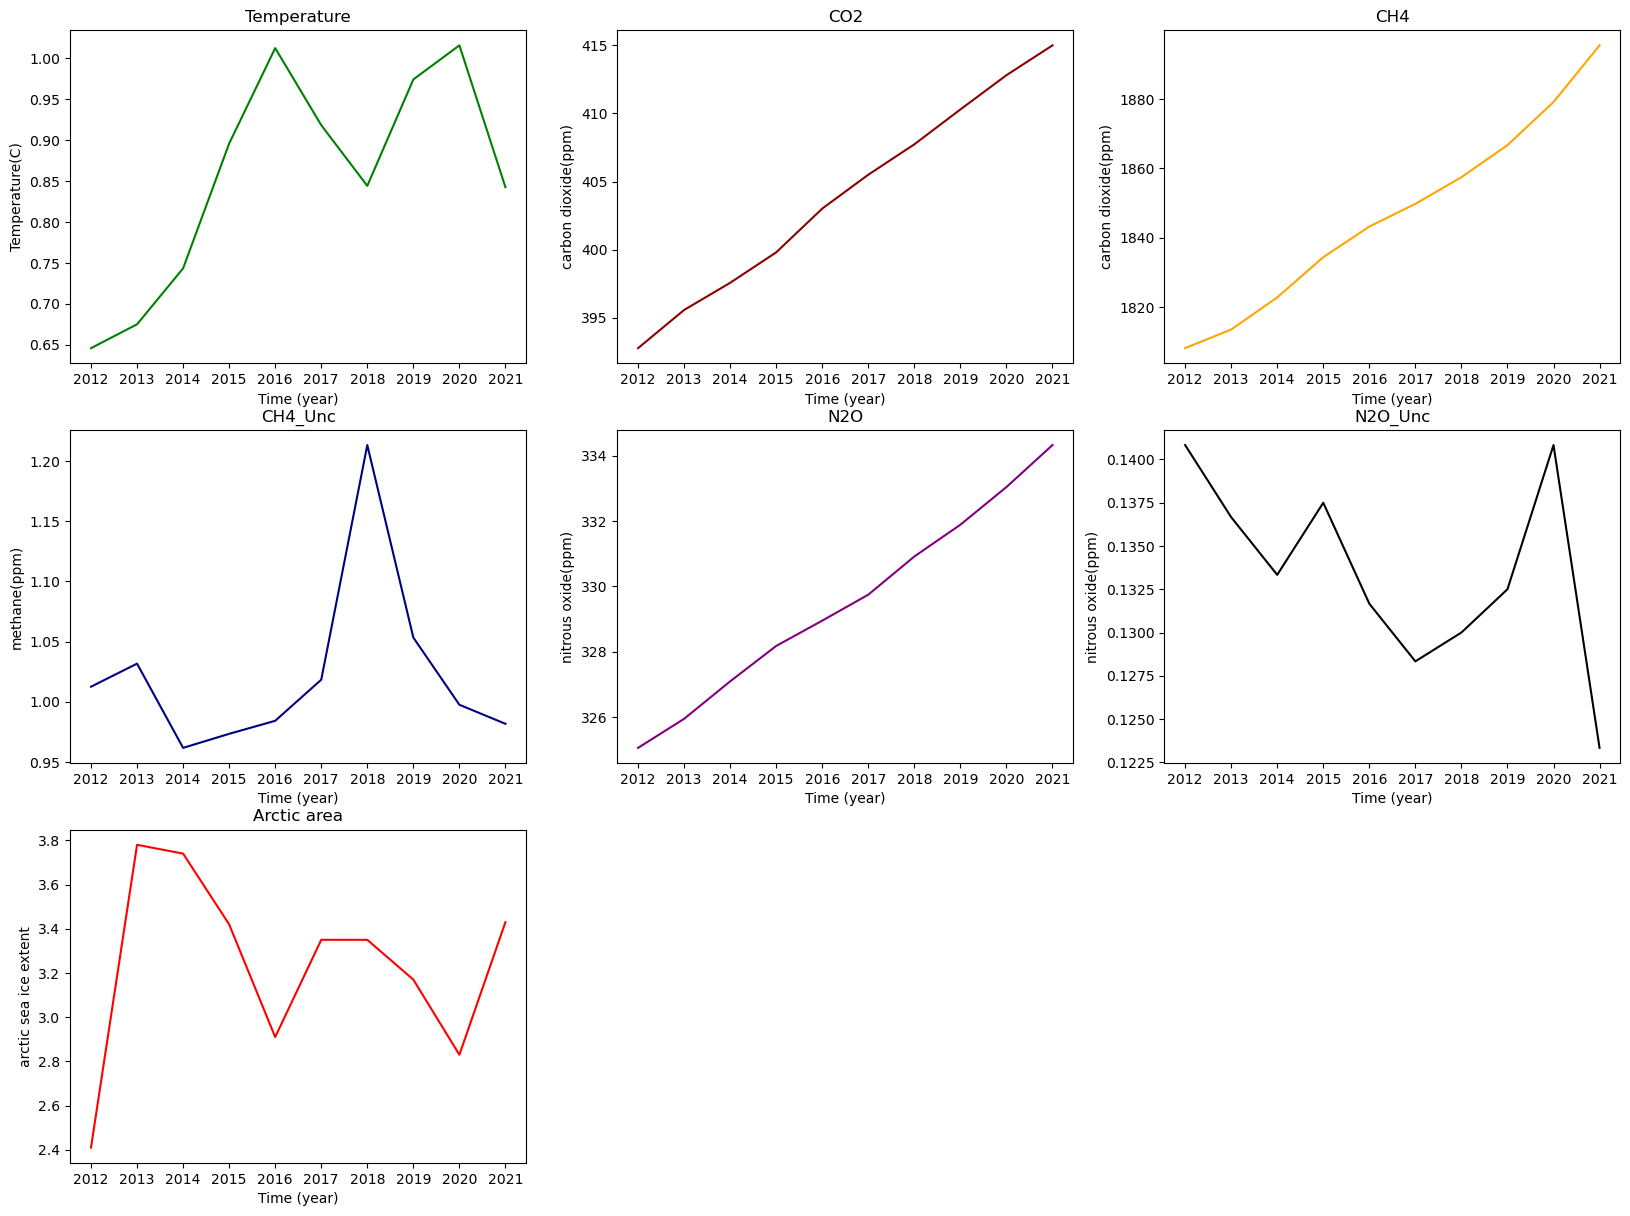

In [79]:
draw_plot2()

The graphs above show the trends for each of the data analysed earlier

In [80]:
def draw_plot_temp():
    figure = plt.figure(figsize=(18,10),dpi = 100)
    i = 0
    unit = ['Temperature(C)','carbon dioxide(ppm)','methane(ppm)','nitrous oxide(ppm)','nitrous oxide(ppm)']
    for index_name in list(corr2):
        axc = figure.add_subplot(2,2, i+1)
        axc.plot(corr2[index_name],color = gl_colors[i])
        axc.set_xticks(list(range(0,150,15))) 
        axc.set_title(index_name) 
        axc.set_xlabel("Time (year)") 
        axc.set_ylabel("%s" % unit[i]) 
        i = i+1

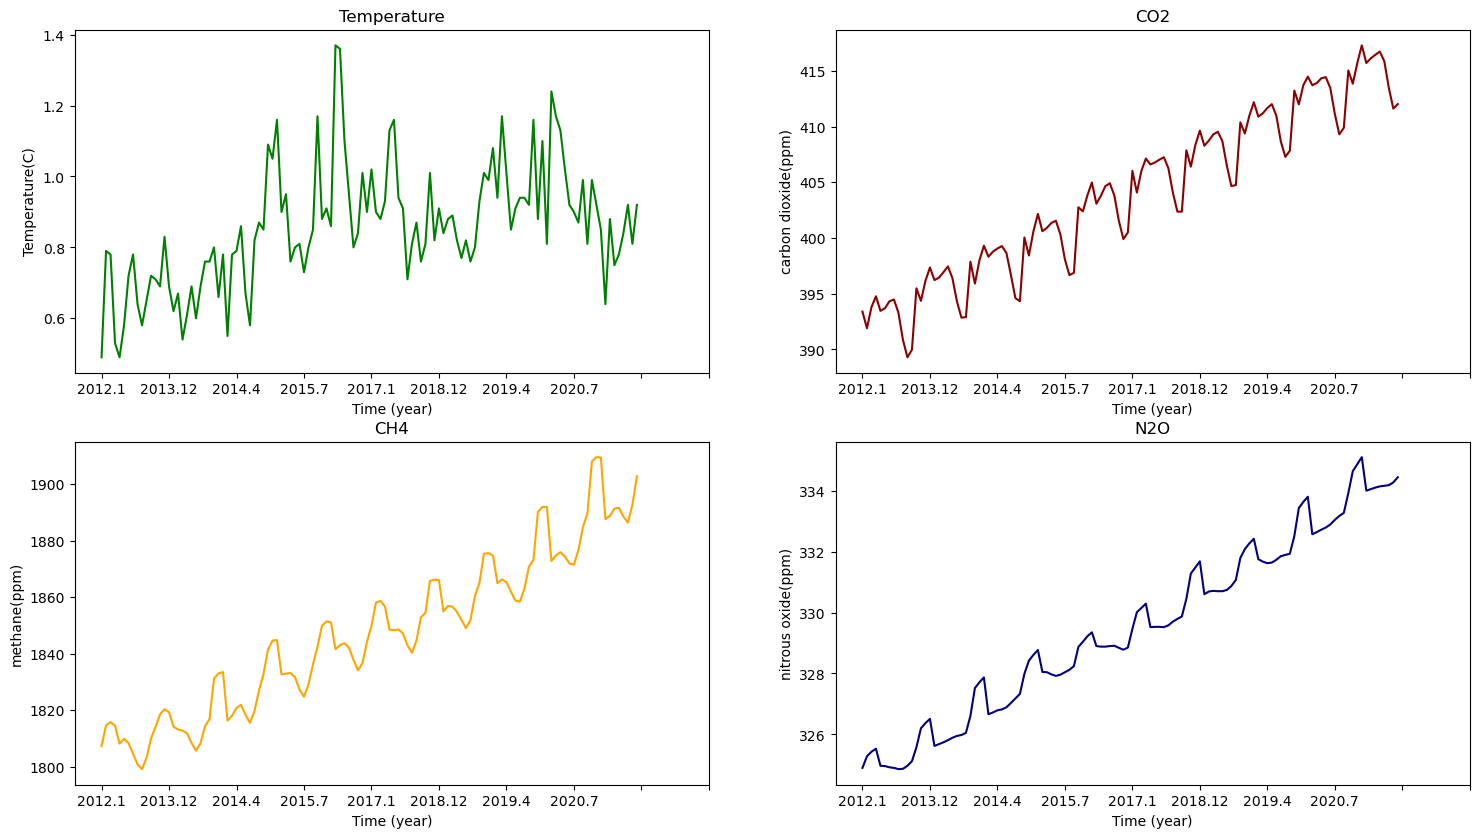

In [81]:
draw_plot_temp()

The graphs above show the trends for each of the data analysed earlier. From these four graphs, the periodicity of the changes in the concentrations of the three gases can be seen more clearly

In [82]:
def box(index_name):
    figure = plt.figure(figsize=(20,15),dpi = 100)#figsize指定图片大小
    i = 0
    ax = figure.add_subplot(3,3, i+1)
    ax = global_dict[index_name]["month"].boxplot(figsize=(12,6), fontsize=fontsize)
    # ax.set_ylim(0, df_temp_stats["Max"].max()+1)
    ax.set_ylabel(index_name, fontsize=fontsize);

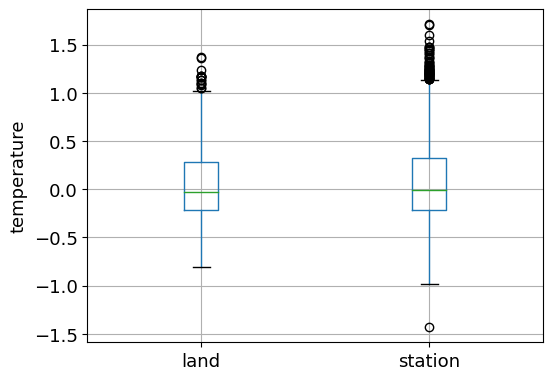

In [83]:
box(gl_names[0])

The box plots not only show the median values but also provide a clear view of the temperature variations. For example, we see a number of outliers for both station and land, indicating that individual months were particularly hot, well above that normal median temperature.

## Correlations Between Index
I will define a single function that calculates the pairwise Pearson correlation between the columns and display it as a 'heat map' visualisation.

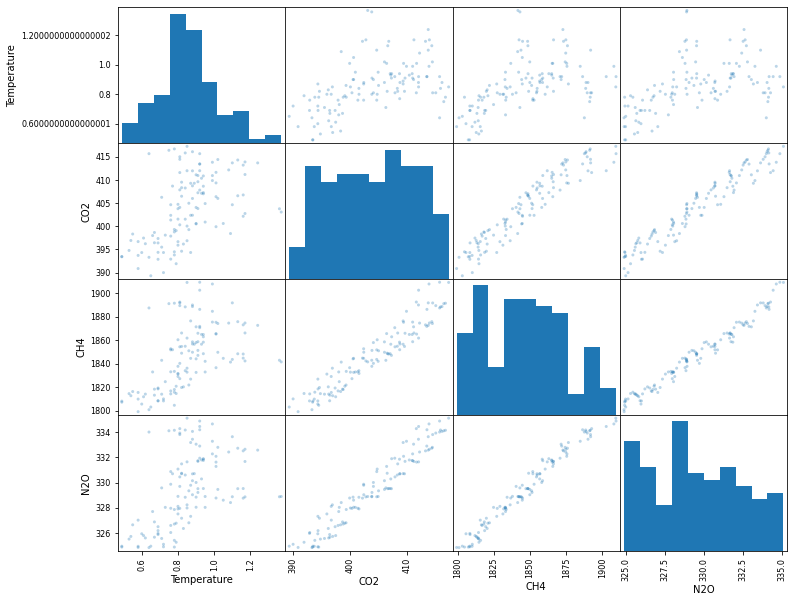

In [84]:
ax = scatter_matrix(corr2, figsize=(12,10), alpha=0.3)

The above graph shows the correlation between temperature, CO2, CH4 and N2O by means of 'heat map' visualisation.

In [85]:
def plot_heatmap(title, df_in, figsize=(5.5, 5)):
    df_corr = df_in.corr()
    # create a color palettte
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # display the heatmap
    f, ax = plt.subplots(figsize=figsize,dpi = 100)
    sns.heatmap(df_corr, square=True, cbar=False,
                annot=True, cmap=cmap, linewidths=0.5, vmin=-1)
    ax.set_title(title)

First, look at the correlation heatmap for temperature:

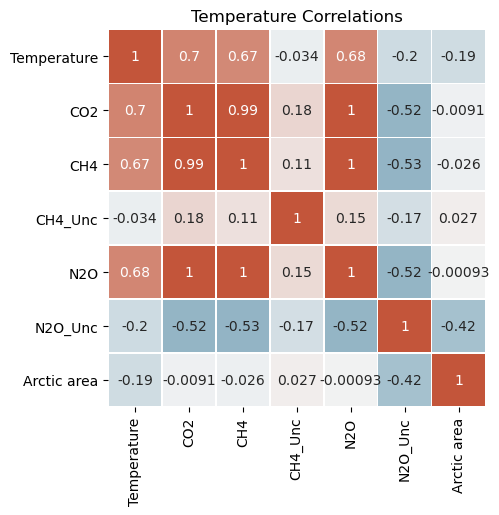

In [86]:
plot_heatmap("Temperature Correlations", corr)

The graph shows that temperature changes are clearly influenced by co2, CH4 and N2O concentrations。Negative correlation between temperature and arctic area

CO2, CH4 and N2O are highly correlated

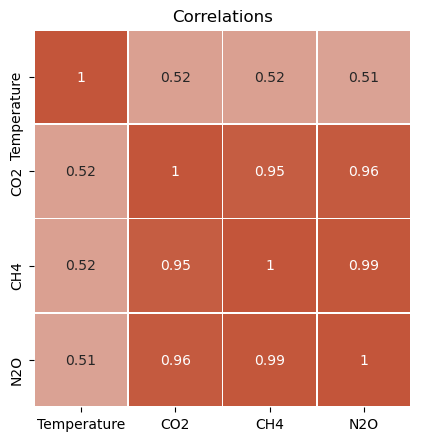

In [87]:
plot_heatmap("Correlations", corr2)

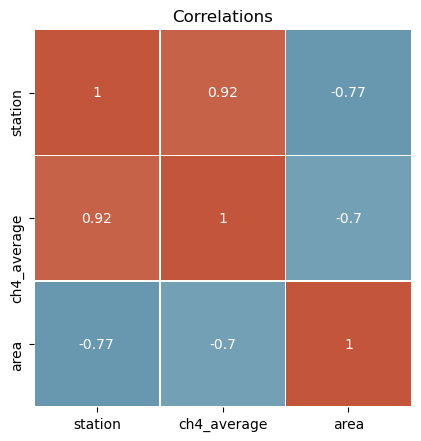

In [88]:
plot_heatmap("Correlations", tca)

Negative correlation between temperature and arctic area

CH4 and temperature are highly correlated

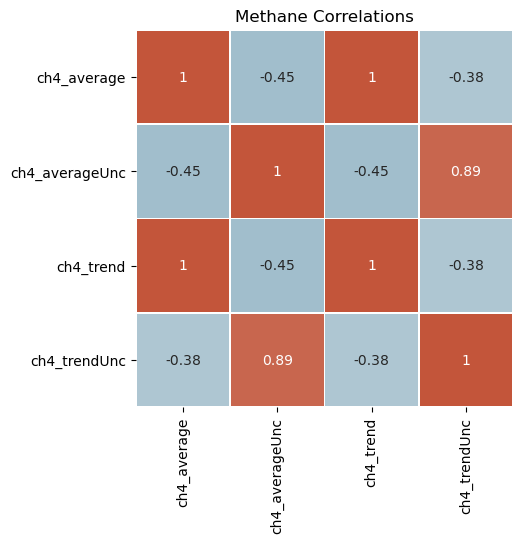

In [89]:
plot_heatmap("Methane Correlations", global_dict["methane"]["year"])

Determining the relevance of data in Methane tables

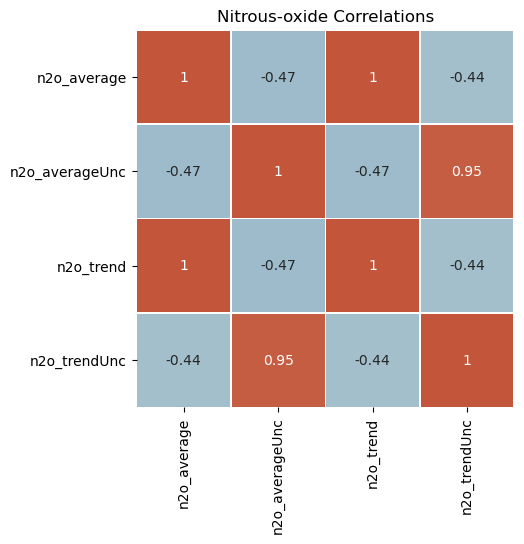

In [90]:
plot_heatmap("Nitrous-oxide Correlations", global_dict["nitrous-oxide"]["year"])

## Conclusion

In this assignment I have analysed four types of data related to global warming: temperature, CO2 concentration, methane concentration, N2O concentration and Arctic ocean ice area. As I expected all three data were previously linked to some degree, and in particular the three greenhouse gases were found to have a high degree of previous interaction.

From 1880 to 1981 the Earth's temperature continued to increase, and even after 1981 the rate of temperature increase became more rapid. So the current rate of global warming is unnatural.
The Earth's temperature is closely linked to the proportion of gases such as carbon dioxide, methane and nitrous oxide in the atmosphere. The increase in greenhouse gases leads to an increase in the Earth's temperature.
Arctic warming has led to a reduction in the area of Arctic marine ice and a thawing of the permafrost. This is a process in which large amounts of methane are released into the atmosphere, further contributing to the process of global warming.

A particular challenge of using the Global warming API is that the Global warming data is data with absolutely no associated variables other than all having a time. So, for me, it was a challenge to just start thinking about how to make connections to all this disparate data. Another challenge is understanding the data itself, as the content of the Global warming data is completely different from my specialism and understanding the meaning of some of the data can be difficult for me.

There are interesting avenues to consider to further analyse the data.

The analysis could be extended to different geographical areas of the globe to analyse whether areas with high human activity are more influential in global warming.

If further historical data were available, we could consider identifying in our data regularities in how global temperatures are affected by greenhouse gases, in other words how they are affected and at what times of year the effects are greater.
Similarly, if we had more historical data, we could try to use time series forecasting methods to try to make predictions for variables such as temperature on a monthly basis.